Время начала 14 35

Опустили латунь 14 37

Достали латунь 14 44

включили нагрев калориметра 14 47 (до 18.2)


остановили нагрев калориметра 15 09 (до 18.1)

температура упала на 1-2 градуса 15 20

опустили латунь 15 21

достали латунь опустили медь 15 23

включили нагрев меди 15 31 (было где то 17.4)

остановили нагрев меди 16 00

достали медь 16 15 

опустили латунь 16 18

опустили титан 16 21

греем с титаном 16 26

выключили нагрев 16 46 

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [158]:
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [159]:
class Experiment:
    def __init__(self, filename) -> None:
        self.df = pd.read_csv(filename)
        self.nlines = len(self.df.index) - 1

        print(f"Class initialized (nlines = %d)" % (self.nlines))

    def read_time(self):
        self.time = [get_sec(self.df['Time'][i]) for i in range(1, self.nlines + 1)]
        print(f"Time[%d]" % (len(self.time)))
        # return self.time

    def read_temperature(self):
        self.resistance = [self.df['Value'][i] for i in range(1, self.nlines + 1)]
        self.temperature = [14.583955001619313455*self.resistance[i] + 39.35514018691588785 for i in range(self.nlines)]
        print(f"Temperature[%d]" % (len(self.temperature)))
        # return self.temperature

    def truncate_data(self, n_first):
        self.nlines      = self.nlines - n_first
        self.time        = self.time       [n_first:]
        self.time        = [self.time[i] - self.time[0] for i in range(self.nlines)]
        self.resistance  = self.resistance [n_first:]
        self.temperature = self.temperature[n_first:]
        print("Data successfully truncated")
        print("nlines = %d" % (self.nlines))

    def delete_measuremet_errors(self, sigma_max):
        cnt = 0
        for i in range(1, self.nlines - 1):
            if (self.temperature[i-1] + sigma_max < self.temperature[i] and
                self.temperature[i] > self.temperature[i+1] + sigma_max):
                print("popping dot [%d](%d, %d)" % (i, self.time[i], self.temperature[i]))
                self.time.pop(i)
                self.temperature.pop(i)
                self.resistance.pop(i)
                cnt += 1
        self.nlines -= cnt
        print("current nlines = %d" % (self.nlines))



In [160]:
Experiment = Experiment('data.csv')


Class initialized (nlines = 8877)


In [161]:
Experiment.read_time()
Experiment.read_temperature()
Experiment.truncate_data(750)
Experiment.delete_measuremet_errors(1)

Time[8877]
Temperature[8877]
Data successfully truncated
nlines = 8127
popping dot [1730](1736, 316)
current nlines = 8126


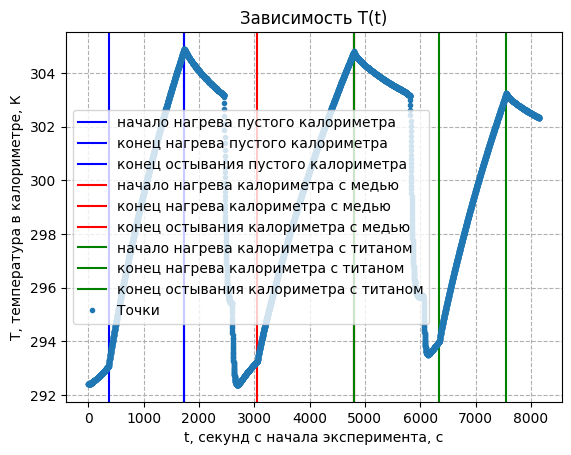

In [173]:
plt.figure()
plt.xlabel("t, секунд с начала эксперимента, с")
plt.ylabel("Т, температура в калориметре, К")
plt.title('Зависимость Т(t)')
plt.grid(True, linestyle = '--')
plt.errorbar(Experiment.time, Experiment.temperature, fmt=".", label="Точки")
plt.axvline(x = 368, color = 'b', label = 'начало нагрева пустого калориметра')
plt.axvline(x = 1735, color = 'b', label = 'конец нагрева пустого калориметра')
plt.axvline(x = 1735, color = 'b', label = 'конец остывания пустого калориметра')

plt.axvline(x = 3058, color = 'r', label = 'начало нагрева калориметра с медью')
plt.axvline(x = 4803, color = 'r', label = 'конец нагрева калориметра с медью')
plt.axvline(x = 4803, color = 'r', label = 'конец остывания калориметра с медью')

plt.axvline(x = 6348, color = 'g', label = 'начало нагрева калориметра с титаном')
plt.axvline(x = 7559, color = 'g', label = 'конец нагрева калориметра с титаном')
plt.axvline(x = 8152, color = 'g', label = 'конец остывания калориметра с титаном')
plt.legend()
plt.show()